In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import pandas as pd
np.random.seed(1)

/Users/saurabhdeshmukh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
X_train=np.load("exam2_train_x.npy")
Y_train=np.load("exam2_train_y.npy")
X_test=np.load("exam2_test_x.npy")
Y_test=np.load("exam2_test_y.npy")
classes=[0,1,2,3,4,5]

In [3]:
X_train=(X_train/255)-0.5
X_test=(X_test/255)-0.5

In [4]:
def one_hot_Encoding(Y,classes):
    Yout=np.zeros((Y.shape[0],len(classes)))
    for i in range(0,len(Y)-1):
        indx=classes.index(Y[i])
        Yout[i,indx]=1
    return Yout

In [5]:
Y_train=one_hot_Encoding(Y_train,classes)
Y_test=one_hot_Encoding(Y_test,classes)

In [6]:
def create_placeholders(H, W, C, y):
    X = tf.placeholder(tf.float32, [None, H, W, C])
    Y = tf.placeholder(tf.float32, [None, y])
    return X, Y

In [7]:
def initialize_parameters():
    tf.set_random_seed(1)                             
    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [8]:
def forward_propagation(X, parameters,architecture):
    W1 = parameters['W1']
    W2 = parameters['W2']
    H1=["0","Input",[X.get_shape()[1],X.get_shape()[1]],X.get_shape()[3]," "," "," "," "]
    architecture[2]=H1
    Z1 = tf.nn.dropout(tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME'),0.5)
    A1 = tf.nn.leaky_relu(Z1)
    H2=["1","Convolution",[A1.get_shape()[1],A1.get_shape()[1]],A1.get_shape()[3],"4,4",1,1,"Leaky_ReLU(0.2),Dropout(0.5)"]
    architecture[3]=H2
    P1 = tf.nn.max_pool(A1, ksize = [1, 8, 8, 1], strides = [1, 8, 8, 1], padding='SAME')
    H3=["2","Pooling",[P1.get_shape()[1],P1.get_shape()[1]],P1.get_shape()[3],"8,8",8,1,"Max"]
    architecture[4]=H3
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
    A2 = tf.nn.leaky_relu(Z2)
    H4=["3","Convolution",[A2.get_shape()[1],A2.get_shape()[1]],A2.get_shape()[3],"2,2",1,1,"Leaky_ReLU(0.2)"]
    architecture[5]=H4
    P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding='SAME')
    H5=["4","Pooling",[P2.get_shape()[1],P2.get_shape()[1]],P2.get_shape()[3],"4,4",4,1,"Max"]
    architecture[6]=H5
    P = tf.contrib.layers.flatten(P2)
    H6=["5","flatten",P.get_shape()[1]," "," "," "," "," "]
    architecture[7]=H6
    Z3 = tf.contrib.layers.fully_connected(P, 32, activation_fn=tf.nn.relu)
    H6=["6","fully_connected",[Z3.get_shape()[1]]," "," "," "," ","Leaky_ReLU(0.2)"]
    architecture[8]=H6
    Z4 = tf.contrib.layers.fully_connected(Z3, 6, activation_fn=None)
    H7=["7","fully_connected",[Z4.get_shape()[1]]," "," "," "," "," "]
    architecture[9]=H7
    return Z4,architecture

In [9]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z3, labels=Y))
    return cost

In [10]:
def model(X_train, Y_train, X_test, Y_test, learning_rate,num_epochs, batch_size,architecture):
    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (m, H, W, C) = X_train.shape             
    y = Y_train.shape[1]                            
    costs = []                                       
    X, Y = create_placeholders(H, W, C, y)  
    parameters = initialize_parameters() 
    Z3,architecture = forward_propagation(X, parameters,architecture)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            batch_cost = 0
            num_batches=int(m/batch_size)
            shuffle_indices = np.random.permutation(np.arange(len(Y_train)))
            X_train = X_train[shuffle_indices]
            Y_train = Y_train[shuffle_indices]

            for i in range(0, len(Y_train) // batch_size):
                start = i * batch_size
                batch_x = X_train[start:start + batch_size]
                batch_y = Y_train[start:start + batch_size]
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:batch_x, Y:batch_y})
               
                batch_cost += temp_cost / num_batches
      
            if epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, batch_cost))
            if epoch % 1 == 0:
                costs.append(batch_cost)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:%.2f" %(train_accuracy*100))
        print("Test Accuracy:%.2f" %(test_accuracy*100))
        return architecture

Cost after epoch 0: 1.657366
Cost after epoch 5: 0.605762
Cost after epoch 10: 0.336424
Cost after epoch 15: 0.204611
Cost after epoch 20: 0.124855
Cost after epoch 25: 0.255678
Cost after epoch 30: 0.069283
Cost after epoch 35: 0.064965
Cost after epoch 40: 0.061844
Cost after epoch 45: 0.133326
Cost after epoch 50: 0.142444
Cost after epoch 55: 0.033913


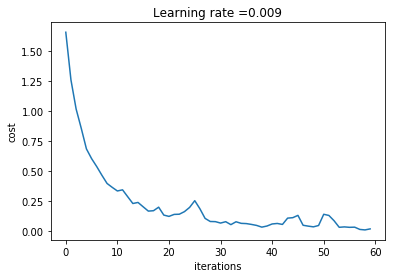

Train Accuracy:99.41
Test Accuracy:93.33


In [11]:
architecture = {}
header=["Layer","Type","Size","Channels","Kernel size","Stride","Padding","Function"]
architecture[1]=header
architecture=model(X_train, Y_train, X_test, Y_test,0.009,60,51,architecture)

In [12]:
pd.DataFrame([architecture[2],architecture[3],architecture[4],architecture[5],architecture[6],architecture[7],architecture[8],architecture[9]], columns=architecture[1])

,Layer,Type,Size,Channels,Kernel size,Stride,Padding,Function
0,0,Input,"[64, 64]",3,,,,
1,1,Convolution,"[64, 64]",8,"4,4",1,1,"Leaky_ReLU(0.2),Dropout(0.5)"
2,2,Pooling,"[8, 8]",8,"8,8",8,1,Max
3,3,Convolution,"[8, 8]",16,"2,2",1,1,Leaky_ReLU(0.2)
4,4,Pooling,"[2, 2]",16,"4,4",4,1,Max
5,5,flatten,64,,,,,
6,6,fully_connected,[32],,,,,Leaky_ReLU(0.2)
7,7,fully_connected,[6],,,,,


In [13]:
tf.__version__

'1.5.0'